In [144]:
import sys
sys.path.append('../src')

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px


from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator

import daft

from sklearn.impute import KNNImputer

* Abaixo são criadas as funções que vão nos ajudar nos processos de modelagem e ajuste dos dados.

In [146]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

def getSignificantLags(y, nLags = 5, alpha=0.05):
    Pacf, Pacf_intervalos =  pacf(x=y, nlags=nLags, alpha=alpha)
   
    significantLags = []
    for i in range(1, len(Pacf)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if Pacf[i] < Pacf_intervalos[i][0] - Pacf[i] or Pacf[i] > Pacf_intervalos[i][1] - Pacf[i]:
            significantLags.append(i)
    print('Lags Significantes:', significantLags)
    return significantLags


def getQlTransformation(x=None, bins=2):
    q = []; I = []; categories = list(range(bins))
    lower = x.min()
    quantile = 1 / bins
    cum = quantile
    ql_x = pd.Series(index=x.index, dtype="Int64")  # Garante dtype correto para evitar NaN
    i = 0

    while cum < 1:
        upper = x.quantile(cum)
        ql_x[(x >= lower) & (x < upper)] = categories[i]
        I.append((lower, upper))
        q.append(upper)
        lower = upper
        cum += quantile
        i += 1

    # Último intervalo (para garantir que o maior valor seja incluído)
    ql_x[x >= lower] = categories[-1]
    I.append((lower, x.max()))
    
    return {'ql_x': ql_x, 'I': I, 'bins': bins, 'categories': categories, 'quantile': quantile}


def getEvidence(df,X_qualitative,X_quantitative, index):
    qualitativeRow = df.loc[index, X_qualitative]  # Seleciona diretamente as colunas qualitativas
    quantitativeRow = df.loc[index, X_quantitative]  # Seleciona diretamente as colunas quantitativas
    
    # Converte para dicionários
    qualitative_dic = qualitativeRow.to_dict()
    quantitative_dic = quantitativeRow.to_dict()
    
    return {'qualitative': qualitative_dic, 'quantitative': quantitative_dic}  # Corrige a chave errada


def predict(y_qualitative, df, modelInfer, qlTrans):
    preds = pd.DataFrame(index=df.index)
    preds['~Valor_ql'] = pd.Series(index=df.index, dtype=object)
    preds['~Valor_de_Venda'] = pd.Series(index=df.index, dtype=float)
    
    for i in range(df.shape[0]):
        ev_i = getEvidence(df,X_qualitative, X_quantitative, i)

        # Usa as chaves corretas ('qualitative' e 'quantitative')
        dist_i = modelInfer.query([y_qualitative], evidence=ev_i['qualitative'])

        # Encontra o índice da maior probabilidade corretamente
        index = np.argmax(dist_i.values)

        # Obtém a predição qualitativa
        qlPred_i = dist_i.state_names[y_qualitative][index]
        preds.loc[df.index[i], '~Valor_ql'] = qlPred_i

        # Calcula a predição quantitativa
        qtPred_i = 0
        for j in range(len(dist_i.values)):
            pj = dist_i.values[j]

            # Obtém os valores correspondentes
            xj = pd.Series(ev_i['quantitative'].values())[pd.Series(ev_i['qualitative'].values()) == j]

            if xj.empty:
                xj = pd.Series([qlTrans['I'][j]])  # Usa um Series para evitar erro

            vj = np.mean([val[0] if isinstance(val, tuple) else val for val in xj])

            qtPred_i += pj * vj

        preds.loc[df.index[i], '~Valor_de_Venda'] = qtPred_i               
    
    return preds


* Os dados representam os preços da gasolina de forma semanal, abrangendo o período de 2019 a 2024. Durante esse período, observou-se uma variação significativa nos preços devido a uma série de fatores, como as eleições, a pandemia e a forte valorização do dólar. Esses eventos tiveram um impacto considerável nos preços da gasolina, resultando em flutuações abruptas e mudanças nas tendências de mercado. A análise desses dados exige a consideração desses fatores externos, que podem ter influenciado a dinâmica de preços de maneira substancial.

,Data da Coleta,Produto,Valor_de_Venda
0,2018-12-30,GASOLINA,4.184500
1,2019-01-06,GASOLINA,4.063250
2,2019-01-13,GASOLINA,4.028167
3,2019-01-20,GASOLINA,3.952458
4,2019-01-27,GASOLINA,3.903375


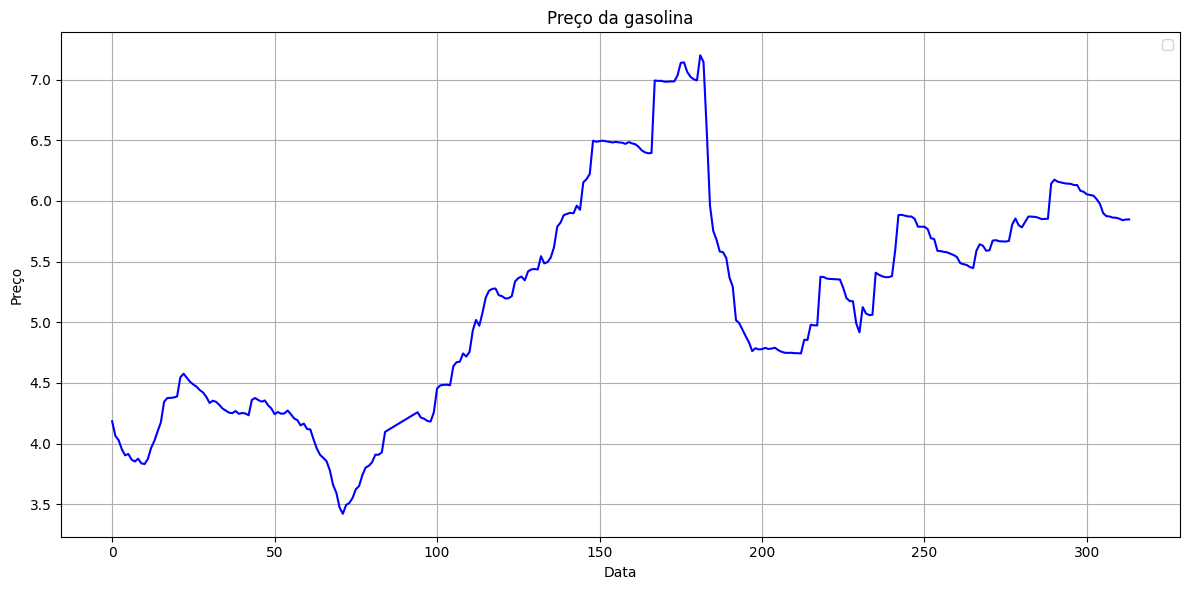

In [147]:

data = pd.read_csv("../data/JOAO PESSOA.csv")

# Renomeando a coluna
data.rename(columns={'Valor de Venda': 'Valor_de_Venda'}, inplace=True)

# Exibindo as primeiras linhas do dataframe para verificar
display(data.head())



imputer = KNNImputer(n_neighbors=1)

data['Valor_de_Venda'].interpolate(method='linear', inplace=True)  # Interpola linearmente


# Plotar valores reais e previstos para a cidade
plt.figure(figsize=(12,6))
plt.plot(data['Valor_de_Venda'],  color='blue')

# Títulos e legendas
plt.title('Preço da gasolina')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

* A função getQlTransformation, utilizada abaixo, realiza a discretização dos valores da série numérica em quantis, dividindo os dados em um número especificado de bins (intervalos). No nosso caso a função foi aplicada à coluna ````Valor_de_Venda```` do DataFrame data, utilizando 7 bins.  
Com isto criamos uma nova coluna no dataframe com esses valores discretizados.

In [148]:
bins = 7
qlTrans = getQlTransformation(x=data['Valor_de_Venda'], bins=bins)

data = pd.DataFrame({'Data da Coleta':data['Data da Coleta'],'Valor_de_Venda': data['Valor_de_Venda'], 'Valor_ql': qlTrans['ql_x']}, index=data.index)

display(data)

,Data da Coleta,Valor_de_Venda,Valor_ql
0,2018-12-30,4.184500,1
1,2019-01-06,4.063250,0
2,2019-01-13,4.028167,0
3,2019-01-20,3.952458,0
4,2019-01-27,3.903375,0
...,...,...,...
309,2024-12-01,5.861579,5
310,2024-12-08,5.853684,5
311,2024-12-15,5.841053,5
312,2024-12-22,5.846842,5


* Abaixo é feita a análise dos lags relevantes, como os lags relevantes nas variáveis discretas foi somente o primeiro usaremos também só um valor de lag para a variável qualitativa.

In [149]:
significant_lags_discrete = getSignificantLags(data['Valor_ql'], nLags = 5, alpha=0.05)
significant_lags_continue = getSignificantLags(data['Valor_de_Venda'], nLags = 5, alpha=0.05)

print('lag discrete value',significant_lags_discrete)
print('lag continue value',significant_lags_continue)

Lags Significantes: [1]
Lags Significantes: [1, 2, 4]
lag discrete value [1]
lag continue value [1, 2, 4]


* Abaixo criamos as novas colunas discretas e continuas com o lag de valor 1, em seguida é possivel ver como ficou o dataframe apos todos os tratamentos feitos acima.

In [150]:
# Criar os lags
data['Valor_ql_lag1'] = data['Valor_ql'].shift(1)  # Lag de 1 para Valor_ql
data['Valor_de_Venda_lag1'] = data['Valor_de_Venda'].shift(1)  # Lag de 1 para Valor de Venda

# Remover linhas com valores NaN gerados pelos lags
data.dropna(inplace=True)

# Resetar o índice para manter a estrutura organizada
data.reset_index(drop=True, inplace=True)

# Exibir as primeiras linhas do dataframe resultante
display(data.head(5))


,Data da Coleta,Valor_de_Venda,Valor_ql,Valor_ql_lag1,Valor_de_Venda_lag1
0,2019-01-06,4.063250,0,1,4.184500
1,2019-01-13,4.028167,0,0,4.063250
2,2019-01-20,3.952458,0,0,4.028167
3,2019-01-27,3.903375,0,0,3.952458
4,2019-02-03,3.914167,0,0,3.903375


* Separação do conjunto em treinamento e teste.

In [151]:
train_data = data.iloc[:-5]  # Todas as linhas menos as 5 últimas
test_data = data.iloc[-5:]   # Somente as 5 últimas linhas
test_data = test_data.reset_index(drop=True)

print("Tamanho do treino:", train_data.shape)
print("Tamanho do teste:", test_data.shape)


Tamanho do treino: (308, 5)
Tamanho do teste: (5, 5)


* O código Abaixo está organizando as variáveis do conjunto de dados `train_data`, separando-as em qualitativas (discretas) e quantitativas (contínuas) com base nas nossas colunas colunas.  
Ele identifica variáveis preditoras que representam lags da variável dependente e as armazena em listas distintas. Em seguida, cria uma lista de pares associando cada variável qualitativa preditora à variável dependente qualitativa (`Valor_ql`).   
Esse processo podem ser usados para análise ou visualização da relação entre as variáveis categóricas e a variável de interesse.


In [152]:
graph = []
y_qualitative = 'Valor_ql'
y_quantitative = 'Valor_de_Venda'
X_qualitative = [xNm for xNm in train_data.columns if 'Valor_ql_' in xNm and xNm != y_qualitative]
X_quantitative = [xNm for xNm in train_data.columns if 'Valor_de_Venda_' in xNm and xNm != y_quantitative]

for x in X_qualitative:
    graph.append((x, y_qualitative))


* O código abaixo está criando e ajustando um modelo de Rede Bayesiana usando a biblioteca `pgmpy`. Ele utiliza a estrutura de grafo definida anteriormente para construir a relação entre variáveis e aplicar inferência probabilística.  
Após instanciar o modelo com `BayesianNetwork(graph)`, ele é treinado com os dados `train_data` utilizando um estimador bayesiano (`BayesianEstimator`). O parâmetro `prior_type="BDeu"` define um tipo de prior Bayesiano, enquanto `equivalent_sample_size=3*bins` ajusta a suavização das probabilidades para lidar com pequenos conjuntos de dados.  
Por fim, `check_model()` verifica se a estrutura e os parâmetros do modelo estão corretamente definidos, garantindo que não haja inconsistências na nossa rede.


In [153]:
beModel = BayesianNetwork(graph)
beModel.fit(train_data, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=3*bins)

beModel.check_model()

True

* Abaixo podemos ver o grafo da nossa rede bayesiana esta estruturado.

<Axes: >

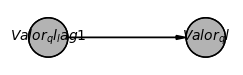

In [154]:
import matplotlib.pyplot as plt

# Criar o gráfico Daft
daft1 = beModel.to_daft(node_pos='planar', latex=True)


# Renderizar o gráfico
daft1.render()


* O resultado exibe a Tabela de Probabilidade Condicional (CPT) da variável `Valor_ql` em função de `Valor_ql_lag1` dentro da Rede Bayesiana.  
Cada linha representa uma possível categoria de `Valor_ql`, enquanto as colunas indicam diferentes estados da variável defasada (`Valor_ql_lag1`). Os valores na tabela correspondem às probabilidades condicionais \( P(Valor\_ql | Valor\_ql\_lag1) \).  

* A distribuição de probabilidades sugere que quando `Valor_ql_lag1` assume o estado 6, há uma alta probabilidade (≈ 90.48%) de `Valor_ql` também ser 6, enquanto os outros estados têm probabilidades muito menores. Isso indica uma forte autocorrelação para esse estado específico.  

* A baixa probabilidade associada aos demais valores de `Valor_ql` sugere que, com base nos dados de treinamento e no estimador bayesiano utilizado, o estado 6 de `Valor_ql_lag1` influencia fortemente a manutenção desse mesmo estado na próxima observação.


In [155]:
print(beModel.get_cpds('Valor_ql'))  # conditional

+---------------+-----+----------------------+
| Valor_ql_lag1 | ... | Valor_ql_lag1(6)     |
+---------------+-----+----------------------+
| Valor_ql(0)   | ... | 0.008928571428571428 |
+---------------+-----+----------------------+
| Valor_ql(1)   | ... | 0.008928571428571428 |
+---------------+-----+----------------------+
| Valor_ql(2)   | ... | 0.008928571428571428 |
+---------------+-----+----------------------+
| Valor_ql(3)   | ... | 0.008928571428571428 |
+---------------+-----+----------------------+
| Valor_ql(4)   | ... | 0.008928571428571428 |
+---------------+-----+----------------------+
| Valor_ql(5)   | ... | 0.05059523809523809  |
+---------------+-----+----------------------+
| Valor_ql(6)   | ... | 0.9047619047619048   |
+---------------+-----+----------------------+


* O código implementa uma função `predict` que realiza previsões para variáveis qualitativas (`Valor_ql`) e quantitativas (`Valor_de_Venda`) com base em um modelo de inferência Bayesiana (`modelInfer`), usando evidências extraídas de um DataFrame de entrada (`df`).  

* **Estrutura da função `predict`:**
  1. **Inicialização**: Um DataFrame `preds` é criado para armazenar as previsões de `Valor_ql` (qualitativo) e `Valor_de_Venda` (quantitativo) para cada linha de `df`.  
  2. **Iteração sobre o DataFrame**: A função itera sobre as linhas de `df`, extraindo as evidências para cada observação com `getEvidence()`.  
  3. **Inferência qualitativa**: Para cada observação, a função usa `modelInfer.query()` para calcular a distribuição de probabilidade condicional para `Valor_ql` dado as evidências qualitativas. O valor de `Valor_ql` é então atribuído como a classe com a maior probabilidade.  
  4. **Inferência quantitativa**: Para calcular `Valor_de_Venda`, a função realiza uma média ponderada dos valores quantitativos disponíveis, multiplicando as probabilidades das classes qualitativas pela média dos valores quantitativos correspondentes.  
  5. **Previsão**: O DataFrame `preds` é preenchido com as previsões de `Valor_ql` e `Valor_de_Venda` para cada linha de entrada.

* **Uso da função `predict`:**  
  - A função é chamada para realizar previsões no conjunto de dados `test_data`, com o modelo `beInfer` (inferência Bayesiana) e a tabela de transformação `qlTrans` que mapeia as variáveis qualitativas.  
  - O resultado da função `predict` é armazenado em `predics_test`, que contém as previsões de `Valor_ql` e `Valor_de_Venda` para o conjunto de teste.  

* **Concatenando os resultados**:  
  - A função `pd.concat()` é usada para combinar os valores reais de `Valor_ql` e `Valor_de_Venda` com as previsões obtidas, criando o DataFrame `data_predics_test`. Isso permite uma comparação entre os valores reais e as previsões feitas pelo modelo.

* **Objetivo geral**: O processo completo fornece as previsões para o conjunto de teste, permitindo avaliar o desempenho do modelo ao comparar os valores previstos com os valores reais.


In [156]:
predics_test = predict(y_qualitative='Valor_ql', df=test_data, modelInfer=beInfer, qlTrans=qlTrans)

# Concatenando os valores reais e previstos
data_predics_test = pd.concat([
                      test_data[['Data da Coleta', 'Valor_ql', 'Valor_de_Venda']], 
                      predics_test[['~Valor_ql', '~Valor_de_Venda']]], axis=1) 



* Resultado da previsão do conjunto de teste.

In [157]:
display(data_predics_test)

,Data da Coleta,Valor_ql,Valor_de_Venda,~Valor_ql,~Valor_de_Venda
0,2024-12-01,5,5.861579,5,5.776042
1,2024-12-08,5,5.853684,5,5.775179
2,2024-12-15,5,5.841053,5,5.768708
3,2024-12-22,5,5.846842,5,5.758353
4,2024-12-29,5,5.848235,5,5.763099


* Abaixo Plotagem do resultado da previsão.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

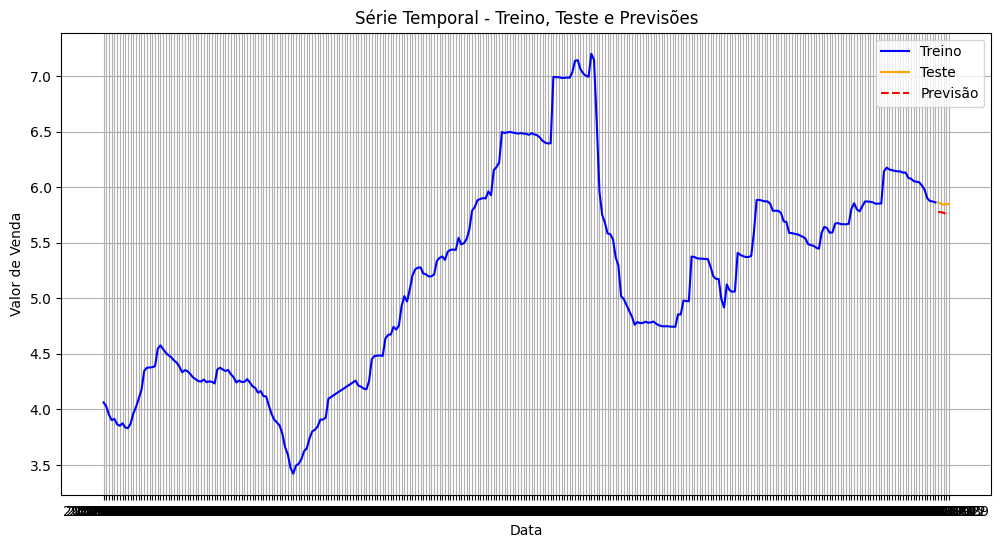

In [158]:
import matplotlib.pyplot as plt

# Criando a figura
plt.figure(figsize=(12, 6))

# Plotando o conjunto de treino
plt.plot(train_data['Data da Coleta'], train_data['Valor_de_Venda'], label='Treino', color='blue')

# Plotando o conjunto de teste
plt.plot(test_data['Data da Coleta'], test_data['Valor_de_Venda'], label='Teste', color='orange')

# Plotando a previsão
plt.plot(test_data['Data da Coleta'], predics_test['~Valor_de_Venda'], label='Previsão', linestyle='dashed', color='red')

# Adicionando título e legendas
plt.title('Série Temporal - Treino, Teste e Previsões')
plt.xlabel('Data')
plt.ylabel('Valor de Venda')
plt.legend()
plt.grid()

# Exibindo o gráfico
plt.show()



* **Acurácia (Valor_ql vs. ~Valor_ql): 1.0000**  
  A acurácia de 1.0 indica que o modelo previu corretamente todas as observações para a variável qualitativa `Valor_ql`. Ou seja, para todas as instâncias no conjunto de teste, a previsão de `~Valor_ql` foi idêntica ao valor real de `Valor_ql`. Esse é um ótimo resultado, indicando que o modelo foi extremamente eficaz para prever as classes qualitativas.

* **Coeficiente de determinação $ R^2 $ (Valor_de_Venda vs. ~Valor_de_Venda): -161.0000**  
  O valor de $ R^2 $ negativo é preocupante e sugere que o modelo não está fazendo boas previsões para a variável quantitativa `Valor_de_Venda`.O $ R^2 $ negativo implica que o modelo está pior do que uma simples média dos valores de `Valor_de_Venda` (ou seja, ele não consegue capturar a variabilidade dos dados e pode estar fazendo previsões erradas).  

In [159]:
from sklearn.metrics import r2_score

# Calculando a acurácia para a variável qualitativa
acuracia = 1 - abs(test_data['Valor_ql'] - predics_test['~Valor_ql']).mean()
print(f"Acurácia (Valor_ql vs. ~Valor_ql): {acuracia:.4f}")

# Arredondando os valores para duas casas decimais antes do cálculo do R²
r2_venda = r2_score(test_data['Valor_de_Venda'].round(2), predics_test['~Valor_de_Venda'].round(2))
print(f"Coeficiente de determinação R² (Valor_de_Venda vs. ~Valor_de_Venda): {r2_venda:.4f}")



Acurácia (Valor_ql vs. ~Valor_ql): 1.0000
Coeficiente de determinação R² (Valor_de_Venda vs. ~Valor_de_Venda): -161.0000
